In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import random
from scipy.stats import pearsonr

In [2]:
# import data
base = f"/ptmp/sfassnacht/ratproject/15.07."
anat=nib.load(f"{base}/anatomy.nii.gz")
anat2func=sitk.ReadTransform(f"{base}/anatomy_to_func.txt")


In [3]:
anat_load = anat.get_fdata()
anat_load.shape


(256, 256, 32)

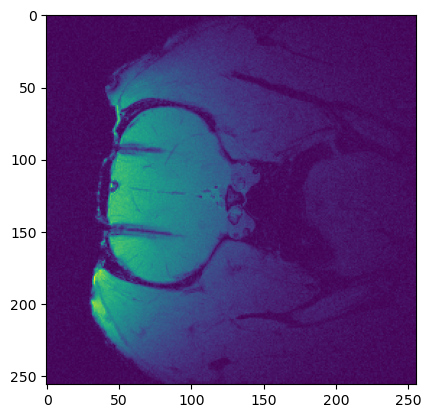

In [4]:
test = anat_load[:,:,25]
plt.imshow(test)
plt.show()

In [5]:
func=nib.load(f"{base}/cleaned_mc_func.nii.gz")

func_ts = func.get_fdata()



In [6]:
func_ts.shape
#type(func_ts)



(64, 64, 16, 2400)

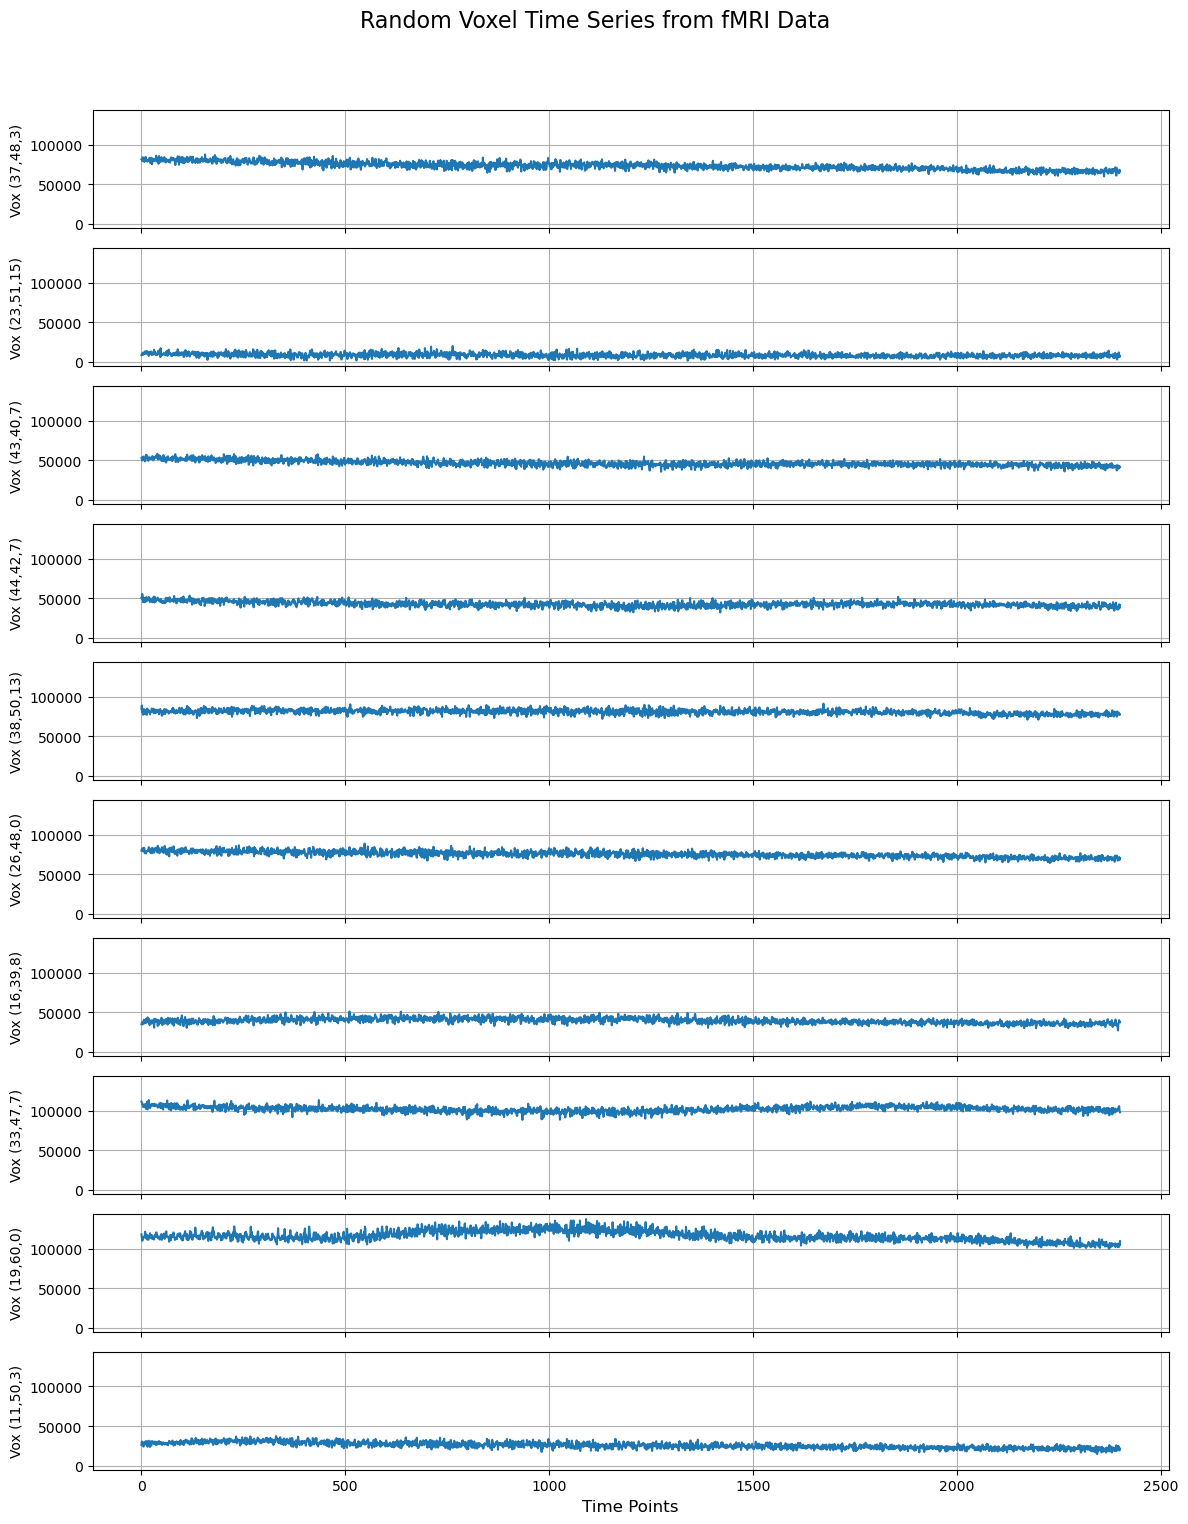

In [7]:
# Make figure larger and prepare 10 subplots stacked vertically
fig, axs = plt.subplots(10, sharex=True, sharey=True, figsize=(12, 16))
fig.suptitle("Random Voxel Time Series from fMRI Data", fontsize=16)

x_dim, y_dim, z_dim, t_dim = func_ts.shape
nonzero_voxels = np.argwhere(np.mean(func_ts, axis=3) > 0)

for i in range(10):
    rand_idx = random.choice(nonzero_voxels)
    x, y, z = rand_idx
    time_series = func_ts[x, y, z, :]

    axs[i].plot(time_series)
    axs[i].set_ylabel(f"Vox ({x},{y},{z})", fontsize=10)
    axs[i].grid(True)

# Only label x-axis once at bottom
axs[-1].set_xlabel("Time Points", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()

In [8]:
roi_mask_1 = sitk.ReadImage(f"{base}/roi_sero_15um.nii.gz", sitk.sitkUInt8)
roi_mask_2 = sitk.ReadImage(f"{base}/roi_sero_150um.nii.gz", sitk.sitkUInt8)
func_4d = sitk.ReadImage(f"{base}/cleaned_mc_func.nii.gz")
func_3d = sitk.Extract(func_4d, size=func_4d.GetSize()[:3] + (0,), index=(0, 0, 0, 0))

In [9]:
resampled_mask = sitk.Resample(
    roi_mask_1,
    func_3d,
    anat2func,
    sitk.sitkNearestNeighbor,
    0,
    roi_mask_1.GetPixelID()
)

In [10]:
sitk.WriteImage(resampled_mask, f"{base}/roi_mask_in_func_space.nii.gz")

In [11]:
func_4d = sitk.ReadImage(f"{base}/cleaned_mc_func.nii.gz")
func_3d = sitk.Extract(func_4d, size=func_4d.GetSize()[:3] + (0,), index=(0, 0, 0, 0))

resampled_mask = sitk.Resample(
    roi_mask_2,
    func_3d,
    anat2func,
    sitk.sitkNearestNeighbor,
    0,
    roi_mask_2.GetPixelID()
)

sitk.WriteImage(resampled_mask, f"{base}/roi_mask_in_func_space_150.nii.gz")

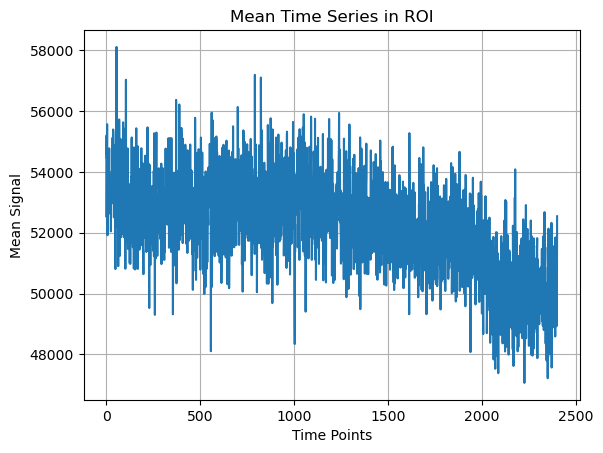

In [12]:
mask_img = nib.load(f"{base}/roi_mask_in_func_space.nii.gz")
mask_data = mask_img.get_fdata()  # Shape: (x, y, z)

# Ensure mask is binary (0/1)
mask_data = mask_data > 0

# Reshape functional image to (num_voxels, time)
flat_func = func_ts[mask_data]  # shape: (num_voxels_in_roi, time)

# Compute mean time series
mean_ts = flat_func.mean(axis=0)  # average over voxels, keep time axis

# Plot it
plt.plot(mean_ts)
plt.title("Mean Time Series in ROI")
plt.xlabel("Time Points")
plt.ylabel("Mean Signal")
plt.grid(True)
plt.show()

In [ ]:
X, Y, Z, T = func_ts.shape

# Extract seed (ROI) mean time series
seed_ts = func_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = func_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map[x, y, z] = corr
            else:
                corr_map[x, y, z] = 0  # or np.nan


In [13]:
z_map = np.arctanh(corr_map)

In [14]:
from nibabel import Nifti1Image

corr_img = Nifti1Image(corr_map, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map.nii.gz")


In [15]:
# lets split the time series into its v3 phases

func_ts.shape
stage = ["pre_injection", "injection", "post_injection"]

pre_injection_ts = func_ts[:,:,:,0:600]
injection_ts = func_ts[:,:,:,601:1200]
post_injection_ts = func_ts[:,:,:,1201:]

pre_injection_ts.shape


(64, 64, 16, 600)

In [16]:
X, Y, Z, T = pre_injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = pre_injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_pre = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = pre_injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_pre[x, y, z] = corr
            else:
                corr_map_pre[x, y, z] = 0  # or np.nan

In [21]:
z_map = np.arctanh(corr_map_pre)


corr_img = Nifti1Image(corr_map_pre, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_pre.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_pre.nii.gz")

In [17]:
X, Y, Z, T = injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_inj = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_inj[x, y, z] = corr
            else:
                corr_map_inj[x, y, z] = 0  # or np.nan

In [18]:
X, Y, Z, T = post_injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = post_injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_post = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = post_injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_post[x, y, z] = corr
            else:
                corr_map_post[x, y, z] = 0  # or np.nan



In [19]:
z_map = np.arctanh(corr_map_post)


corr_img = Nifti1Image(corr_map_post, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_post.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_post.nii.gz")

In [20]:
pre_during_dif = corr_map_pre - corr_map_inj

z_map = np.arctanh(pre_during_dif)


corr_img = Nifti1Image(pre_during_dif, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_diff_1.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_diff_1.nii.gz")

### To-Do's July, 28th

- check z-scoring (what does it do exactly?)
- upload the script to Github (after cleaning)
- seed-based FC for left hemi
- do ratios instead of differences
- 